In [4]:
!gdown 15pKypKxwH6STKOQceOH-KLbqJUznjDuK
! pip install transformers datasets
! pip install -U kaleido
! pip install sentencepiece

Downloading...
From: https://drive.google.com/uc?id=15pKypKxwH6STKOQceOH-KLbqJUznjDuK
To: /content/en_data.csv
100% 907k/907k [00:00<00:00, 80.4MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('en_data.csv')
df = df[df["Ans"].isin(df[df["label"] == "T"]["Ans"])] 

In [7]:
from datasets import load_dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
from transformers import TFBertModel
from transformers import TFAutoModel
from tensorflow.keras import *
from tensorflow.keras import layers
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
class DataLoader:
  def __init__(self,tokenizer,data):
    self.tokenizer = tokenizer
    self.data = data
    self.label_encoder = LabelEncoder()


  def prepare_data(self):
    train_ratio = 0.70
    validation_ratio = 0.10
    test_ratio = 0.20 
    x_train, x_test, y_train, y_test = train_test_split(self.data['sentence'], self.data['label'], test_size=1 - train_ratio)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

    x_train,y_train = x_train.values,to_categorical(self.label_encoder.fit_transform(y_train.values),dtype = 'int32')
    x_test,y_test = x_test.values,to_categorical(self.label_encoder.transform(y_test.values),dtype = 'int32')
    x_valid,y_valid = x_val.values,to_categorical(self.label_encoder.transform(y_val.values),dtype = 'int32')
    return x_train,y_train,x_test,y_test,x_valid,y_valid

  def generate_coded_input(self,data,max_sequence_length=32):
    ids = []
    attn_masks = []
    for i,text in tqdm(enumerate(data)):
        tokenized_text = self.tokenizer.encode_plus(
            text,
            max_length = max_sequence_length,
            truncation = True,
            padding = 'max_length',
            add_special_tokens = True,
            return_tensors = 'tf'
        )
        ids.append(tokenized_text.input_ids[0])
        attn_masks.append(tokenized_text.attention_mask[0])
    return [np.array(ids),np.array(attn_masks)]

In [10]:
class Prob:

  def __init__(self,model_name,data):
    self.model_checkpoint = {
          'bert':"bert-base-uncased",
          'electra':"google/electra-base-discriminator",
          'roberta':"roberta-base",
          'xlm-roberta':"xlm-roberta-base"
          }
    self.model_name = model_name
    self.model_address = self.model_checkpoint[model_name]
    self.tokenizer = AutoTokenizer.from_pretrained(self.model_address)
    self.model = TFAutoModel.from_pretrained(self.model_address)
    self.data_loader = DataLoader(self.tokenizer,data)
    self.x_train,self.y_train,self.x_test,self.y_test,self.x_valid,self.y_valid = self.data_loader.prepare_data()


  def createModel(self,max_length=32):
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
  
    for layer in self.model.layers:
      layer.trainable=False
    model_output = self.model(input_ids, attention_mask=attention_masks)
    sequence_output = model_output.last_hidden_state
    #print(f"** {model_output}")
    pooled_output = sequence_output[:,0,:]
    #dropout = tf.keras.layers.Dropout(0.1)(pooled_output)
    output = layers.Dense(1024,activation="relu")(pooled_output)
    output = tf.keras.layers.Dense(2, activation="softmax")(output)
    self.model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks], outputs=output
    )
    #self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    print(self.model.summary())
    return self.model

  def train_model(self):
    self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=3e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    train_data = self.data_loader.generate_coded_input(self.x_train)
    valid_data = self.data_loader.generate_coded_input(self.x_valid)
    self.history = self.model.fit(train_data, self.y_train,validation_data=(valid_data,self.y_valid),epochs=10, batch_size = 32)

  def plot_accuracy(self):
    plt.plot(self.history.history['accuracy'],label='train')
    plt.plot(self.history.history['val_accuracy'],label='validation')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

  def eval_model(self):
    test_data = self.data_loader.generate_coded_input(self.x_test)
    predicted_y = self.model.predict(test_data)
    number_label_mapping = {0: 'F', 1:'T'}
    y_test_conv = [number_label_mapping[np.argmax(val)] for val in self.y_test]
    predicted_y_conv = [number_label_mapping[np.argmax(val)] for val in predicted_y]
    print('Accuracy:', accuracy_score(y_test_conv, predicted_y_conv))
    print('Classification report:')
    print(classification_report(y_test_conv, predicted_y_conv))
    eval_results = {self.model_name:{}}
    eval_results[self.model_name]['Accuracy'] = accuracy_score(y_test_conv, predicted_y_conv)
    eval_results[self.model_name]['F1 (Micro)'] = f1_score(y_test_conv, predicted_y_conv, average='micro')
    eval_results[self.model_name]['F1 (Macro)'] = f1_score(y_test_conv, predicted_y_conv, average='macro')
    eval_results[self.model_name]['F1 (Weighted)'] = f1_score(y_test_conv, predicted_y_conv, average='weighted')
    eval_results[self.model_name]['Recall (Micro)'] = recall_score(y_test_conv, predicted_y_conv, average='micro')
    eval_results[self.model_name]['Recall (Macro)'] = recall_score(y_test_conv, predicted_y_conv, average='macro')
    eval_results[self.model_name]['Recall (Weighted)'] = recall_score(y_test_conv, predicted_y_conv, average='weighted')
    eval_results[self.model_name]['Precision (Micro)'] = precision_score(y_test_conv, predicted_y_conv, average='micro')
    eval_results[self.model_name]['Precision (Macro)'] = precision_score(y_test_conv, predicted_y_conv, average='macro')
    eval_results[self.model_name]['Precision (Weighted)'] = precision_score(y_test_conv, predicted_y_conv, average='weighted')
    display(pd.DataFrame(eval_results).transpose())

In [11]:
def show_results(model_name):
  model = Prob(model_name,df)
  model.createModel()
  model.train_model()   
  model.eval_model()
  model.plot_accuracy() 

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 32)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 32,                                            

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
41/41 [==============================] - 15s 152ms/step - loss: 0.6916 - accuracy: 0.5922 - val_loss: 0.6783 - val_accuracy: 0.5722
Epoch 2/10
41/41 [==============================] - 3s 82ms/step - loss: 0.6534 - accuracy: 0.6220 - val_loss: 0.6707 - val_accuracy: 0.5775
Epoch 3/10
41/41 [==============================] - 3s 77ms/step - loss: 0.6434 - accuracy: 0.6280 - val_loss: 0.6515 - val_accuracy: 0.5722
Epoch 4/10
41/41 [==============================] - 3s 77ms/step - loss: 0.6430 - accuracy: 0.6143 - val_loss: 0.6486 - val_accuracy: 0.5829
Epoch 5/10
41/41 [==============================] - 3s 77ms/step - loss: 0.6334 - accuracy: 0.6433 - val_loss: 0.6649 - val_accuracy: 0.6150
Epoch 6/10
41/41 [==============================] - 3s 80ms/step - loss: 0.6298 - accuracy: 0.6585 - val_loss: 0.6638 - val_accuracy: 0.6096
Epoch 7/10
41/41 [==============================] - 3s 84ms/step - loss: 0.6403 - accuracy: 0.6288 - val_loss: 0.6541 - val_accuracy: 0.5829
Epoch 8/10


0it [00:00, ?it/s]

12/12 [==============================] - 4s 78ms/step
Accuracy: 0.598404255319149
Classification report:
              precision    recall  f1-score   support

           F       0.61      0.86      0.71       216
           T       0.57      0.24      0.34       160

    accuracy                           0.60       376
   macro avg       0.59      0.55      0.53       376
weighted avg       0.59      0.60      0.55       376



,Accuracy,F1 (Macro),F1 (Micro),F1 (Weighted),Precision (Macro),Precision (Micro),Precision (Weighted),Recall (Macro),Recall (Micro),Recall (Weighted)
bert,0.598404,0.525946,0.598404,0.553549,0.58554,0.598404,0.588567,0.552431,0.598404,0.598404


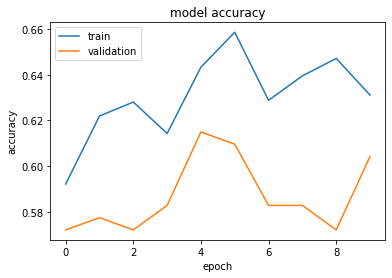

In [12]:
show_results('bert')

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-base-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 32)]         0           []                               
                                                                                                  
 tf_electra_model (TFElectraMod  TFBaseModelOutputWi  108891648  ['input_ids[0][0]',              
 el)                            thPastAndCrossAtten               'attention_masks[0][0]']        
                                tions(last_hidden_s                                               
                                tate=(None, 32, 768                                         

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
41/41 [==============================] - 15s 180ms/step - loss: 0.6862 - accuracy: 0.5610 - val_loss: 0.6720 - val_accuracy: 0.5989
Epoch 2/10
41/41 [==============================] - 3s 78ms/step - loss: 0.6743 - accuracy: 0.5831 - val_loss: 0.6600 - val_accuracy: 0.5882
Epoch 3/10
41/41 [==============================] - 3s 78ms/step - loss: 0.6689 - accuracy: 0.5915 - val_loss: 0.6558 - val_accuracy: 0.6150
Epoch 4/10
41/41 [==============================] - 3s 79ms/step - loss: 0.6650 - accuracy: 0.5976 - val_loss: 0.6546 - val_accuracy: 0.6096
Epoch 5/10
41/41 [==============================] - 3s 86ms/step - loss: 0.6631 - accuracy: 0.5998 - val_loss: 0.6539 - val_accuracy: 0.5989
Epoch 6/10
41/41 [==============================] - 3s 84ms/step - loss: 0.6508 - accuracy: 0.6120 - val_loss: 0.6730 - val_accuracy: 0.6150
Epoch 7/10
41/41 [==============================] - 3s 84ms/step - loss: 0.6592 - accuracy: 0.6075 - val_loss: 0.6557 - val_accuracy: 0.5775
Epoch 8/10


0it [00:00, ?it/s]

12/12 [==============================] - 4s 83ms/step
Accuracy: 0.6648936170212766
Classification report:
              precision    recall  f1-score   support

           F       0.69      0.84      0.76       238
           T       0.57      0.36      0.44       138

    accuracy                           0.66       376
   macro avg       0.63      0.60      0.60       376
weighted avg       0.65      0.66      0.64       376



,Accuracy,F1 (Macro),F1 (Micro),F1 (Weighted),Precision (Macro),Precision (Micro),Precision (Weighted),Recall (Macro),Recall (Micro),Recall (Weighted)
electra,0.664894,0.601467,0.664894,0.643751,0.631313,0.664894,0.648103,0.601327,0.664894,0.664894


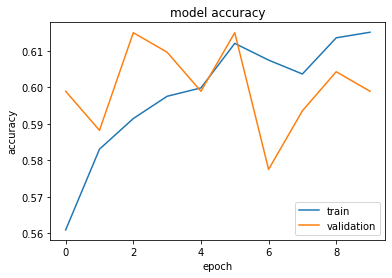

In [13]:
show_results('electra')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 32)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 32,                                          

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
41/41 [==============================] - 14s 150ms/step - loss: 0.6757 - accuracy: 0.6082 - val_loss: 0.6623 - val_accuracy: 0.6310
Epoch 2/10
41/41 [==============================] - 3s 77ms/step - loss: 0.6720 - accuracy: 0.6151 - val_loss: 0.6640 - val_accuracy: 0.6310
Epoch 3/10
41/41 [==============================] - 3s 83ms/step - loss: 0.6644 - accuracy: 0.6159 - val_loss: 0.6607 - val_accuracy: 0.6310
Epoch 4/10
41/41 [==============================] - 3s 84ms/step - loss: 0.6660 - accuracy: 0.6166 - val_loss: 0.6619 - val_accuracy: 0.6310
Epoch 5/10
41/41 [==============================] - 3s 78ms/step - loss: 0.6672 - accuracy: 0.6151 - val_loss: 0.6584 - val_accuracy: 0.6310
Epoch 6/10
41/41 [==============================] - 3s 83ms/step - loss: 0.6658 - accuracy: 0.6128 - val_loss: 0.6607 - val_accuracy: 0.6310
Epoch 7/10
41/41 [==============================] - 3s 84ms/step - loss: 0.6611 - accuracy: 0.6143 - val_loss: 0.6566 - val_accuracy: 0.6310
Epoch 8/10


0it [00:00, ?it/s]

12/12 [==============================] - 5s 93ms/step
Accuracy: 0.5159574468085106
Classification report:
              precision    recall  f1-score   support

           F       0.52      1.00      0.68       194
           T       0.00      0.00      0.00       182

    accuracy                           0.52       376
   macro avg       0.26      0.50      0.34       376
weighted avg       0.27      0.52      0.35       376



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

,Accuracy,F1 (Macro),F1 (Micro),F1 (Weighted),Precision (Macro),Precision (Micro),Precision (Weighted),Recall (Macro),Recall (Micro),Recall (Weighted)
roberta,0.515957,0.340351,0.515957,0.351213,0.257979,0.515957,0.266212,0.5,0.515957,0.515957


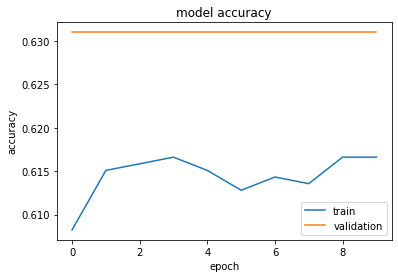

In [14]:
show_results('roberta')

All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 32)]         0           []                               
                                                                                                  
 tfxlm_roberta_model (TFXLMRobe  TFBaseModelOutputWi  278043648  ['input_ids[0][0]',              
 rtaModel)                      thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 32,                                          

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1/10
41/41 [==============================] - 15s 190ms/step - loss: 0.6836 - accuracy: 0.5915 - val_loss: 0.6746 - val_accuracy: 0.5882
Epoch 2/10
41/41 [==============================] - 3s 81ms/step - loss: 0.6749 - accuracy: 0.5983 - val_loss: 0.6730 - val_accuracy: 0.5882
Epoch 3/10
41/41 [==============================] - 3s 82ms/step - loss: 0.6680 - accuracy: 0.6021 - val_loss: 0.6736 - val_accuracy: 0.5882
Epoch 4/10
41/41 [==============================] - 3s 78ms/step - loss: 0.6682 - accuracy: 0.6014 - val_loss: 0.6700 - val_accuracy: 0.5882
Epoch 5/10
41/41 [==============================] - 3s 85ms/step - loss: 0.6680 - accuracy: 0.6006 - val_loss: 0.6684 - val_accuracy: 0.5882
Epoch 6/10
41/41 [==============================] - 3s 78ms/step - loss: 0.6664 - accuracy: 0.6006 - val_loss: 0.6674 - val_accuracy: 0.5882
Epoch 7/10
41/41 [==============================] - 3s 78ms/step - loss: 0.6623 - accuracy: 0.6021 - val_loss: 0.6674 - val_accuracy: 0.5882
Epoch 8/10


0it [00:00, ?it/s]

12/12 [==============================] - 4s 90ms/step
Accuracy: 0.5904255319148937
Classification report:
              precision    recall  f1-score   support

           F       0.59      1.00      0.74       222
           T       0.00      0.00      0.00       154

    accuracy                           0.59       376
   macro avg       0.30      0.50      0.37       376
weighted avg       0.35      0.59      0.44       376



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

,Accuracy,F1 (Macro),F1 (Micro),F1 (Weighted),Precision (Macro),Precision (Micro),Precision (Weighted),Recall (Macro),Recall (Micro),Recall (Weighted)
xlm-roberta,0.590426,0.371237,0.590426,0.438376,0.295213,0.590426,0.348602,0.5,0.590426,0.590426


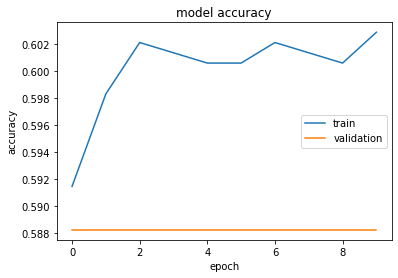

In [15]:
show_results('xlm-roberta')